In [25]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


In [26]:
# Cell 2: Load dataset
data = "data/new_refined.csv"

df = pd.read_csv(data)

X = df.drop(columns=['compressive_strength'])
y = df['compressive_strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Cell 3: Define models and hyperparameters
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 100.0]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.1, 1.0, 10.0, 100.0]}),
    'ElasticNet': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'Extra Trees': (ExtraTreesRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'K-Neighbors': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}),
    'Support Vector': (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']})
}

In [28]:
# Cell 4: Run GridSearchCV
best_models = {}
results = []

for name, (model, params) in models.items():
    print(f"Training {name}...")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    grid = GridSearchCV(pipe, 
                        param_grid={f'regressor__{k}': v for k, v in params.items()}, 
                        scoring='neg_mean_squared_error', 
                        cv=3,
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    best_models[name] = {
        'model': best_model,
        'rmse': rmse,
        'r2': r2,
        'params': grid.best_params_
    }
    
    results.append((name, rmse, r2))


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training Random Forest...
Training Gradient Boosting...
Training Extra Trees...
Training Decision Tree...
Training K-Neighbors...
Training Support Vector...


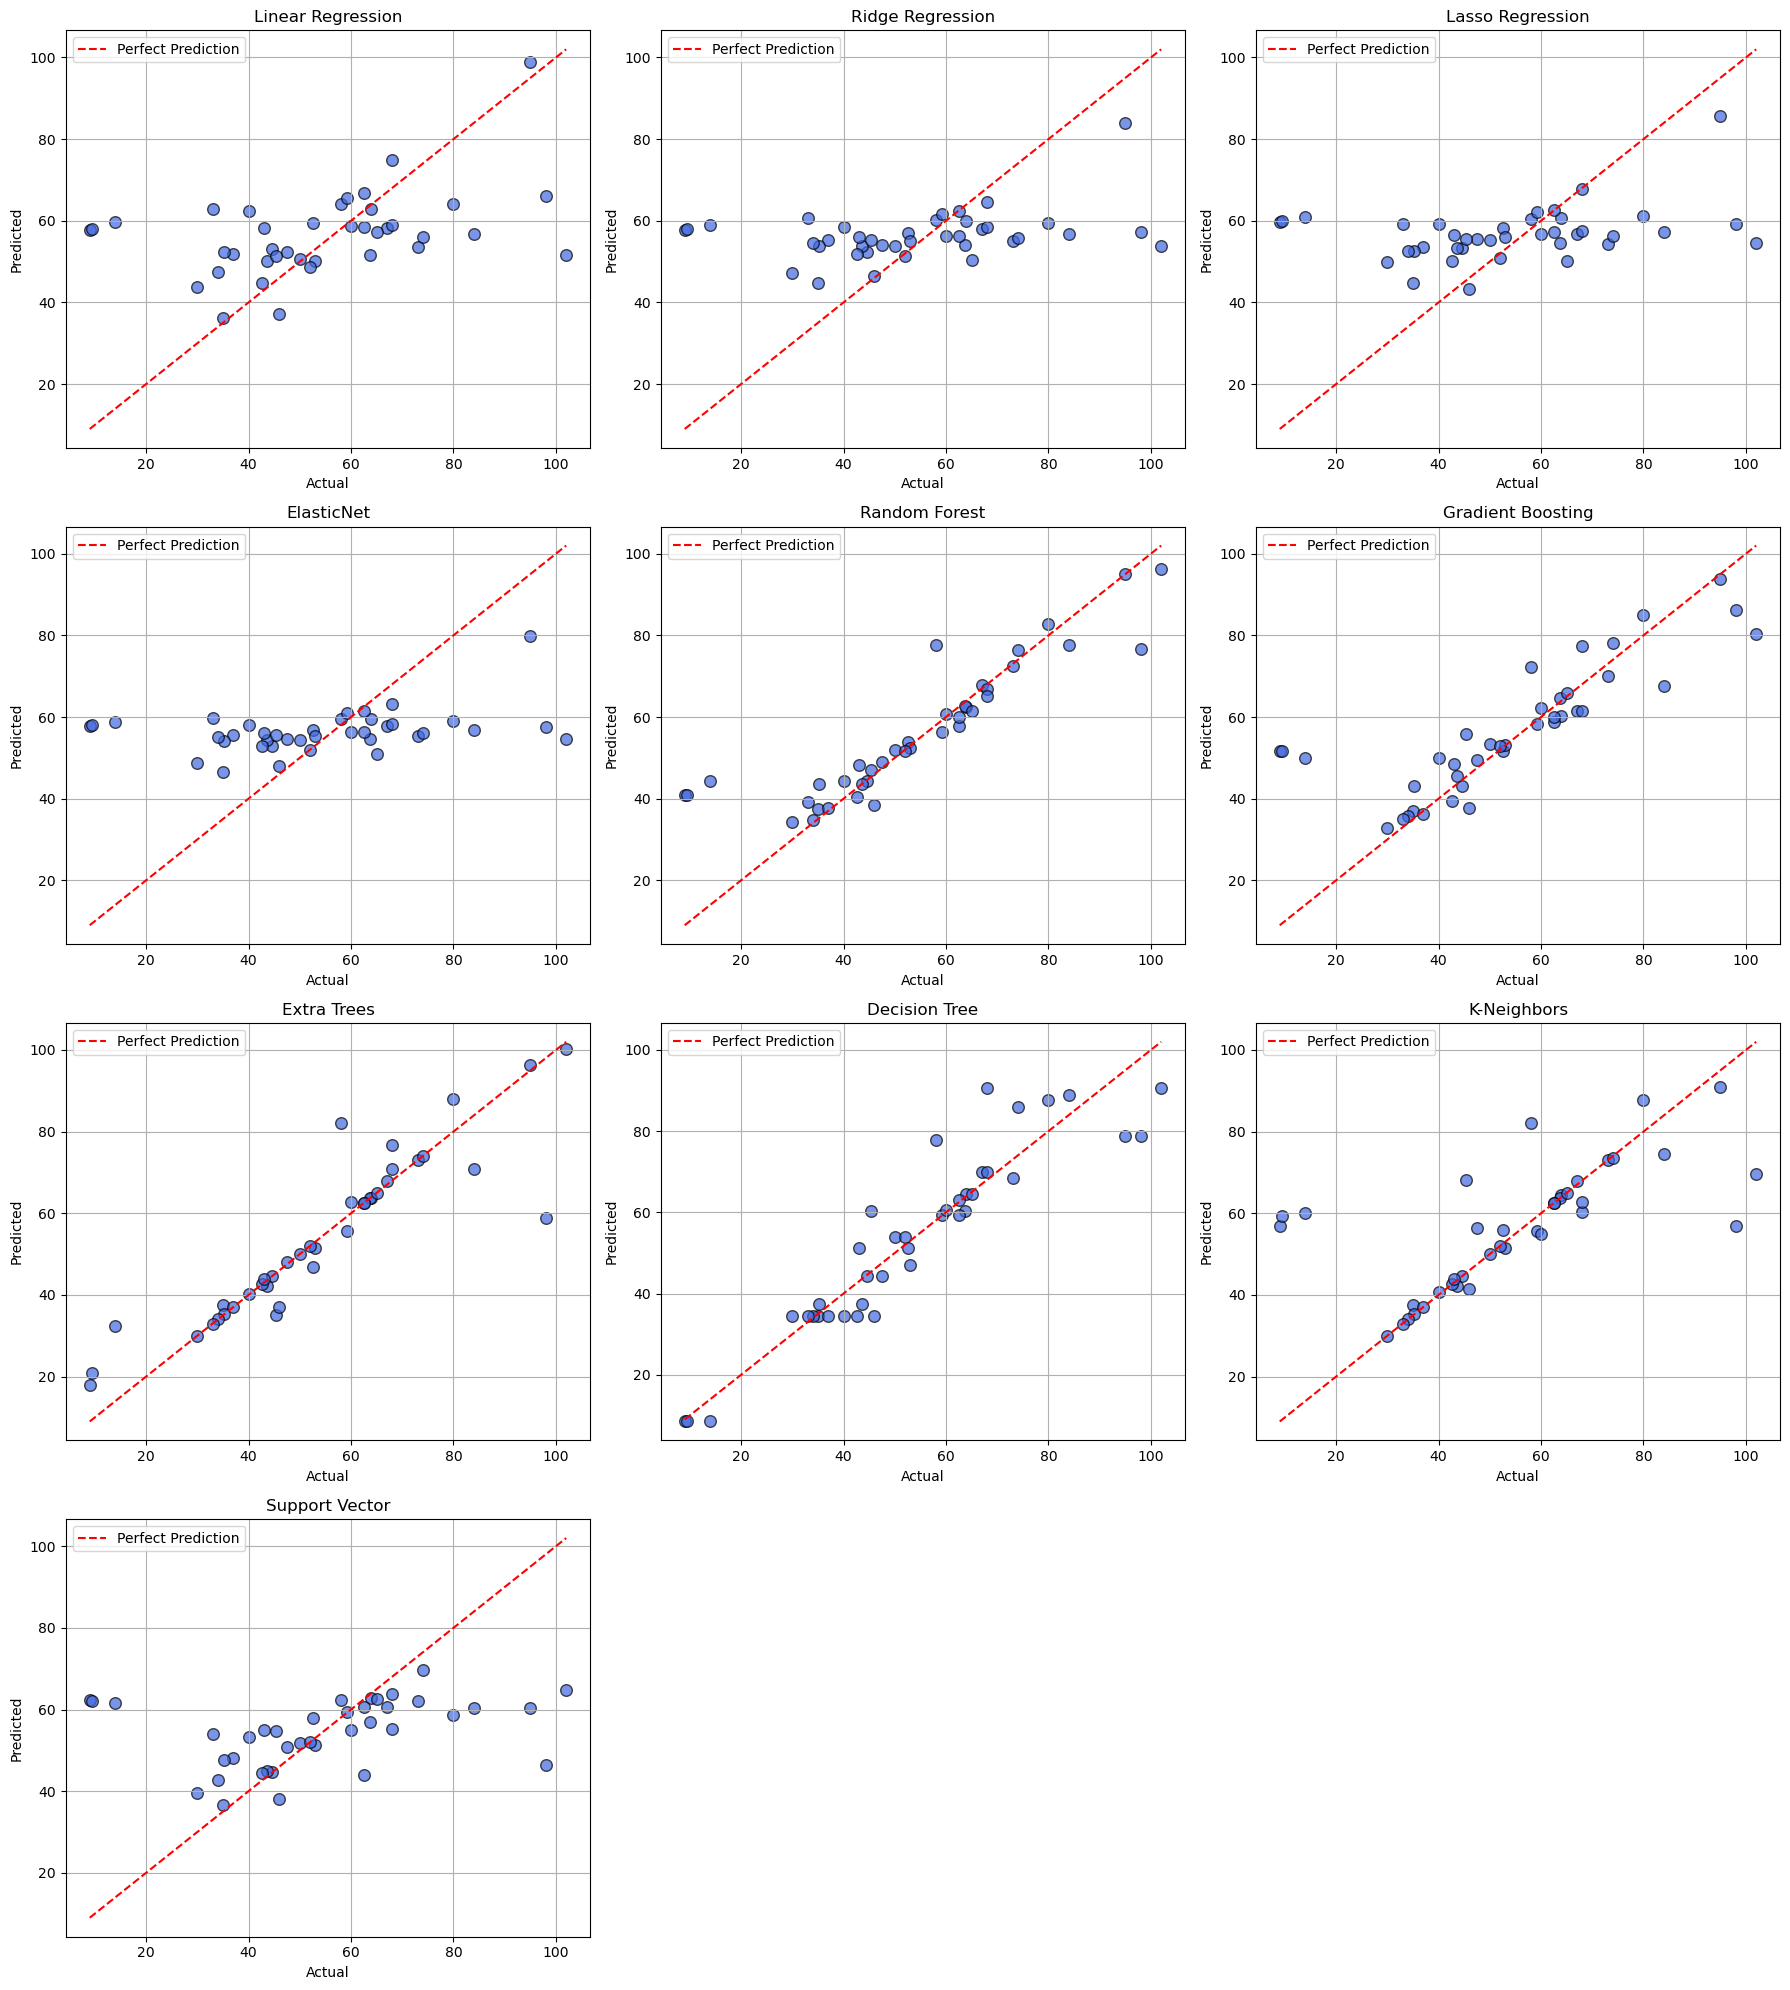

In [29]:
# Cell 5: Display results for all predictions
import matplotlib.pyplot as plt
import numpy as np

# Convert y_test to array
y_true = np.array(y_test)

# Set number of columns per row
cols = 3
models = list(best_models.items())
total = len(models)
rows = (total + cols - 1) // cols  # Ceiling division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()  # Flatten to 1D for easy iteration

for i, (model_name, data) in enumerate(models):
    model = data['model']
    y_pred = model.predict(X_test)

    ax = axes[i]
    ax.scatter(y_true, y_pred, color='royalblue', edgecolor='black', s=70, alpha=0.7)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    
    ax.set_title(f'{model_name}', fontsize=12)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


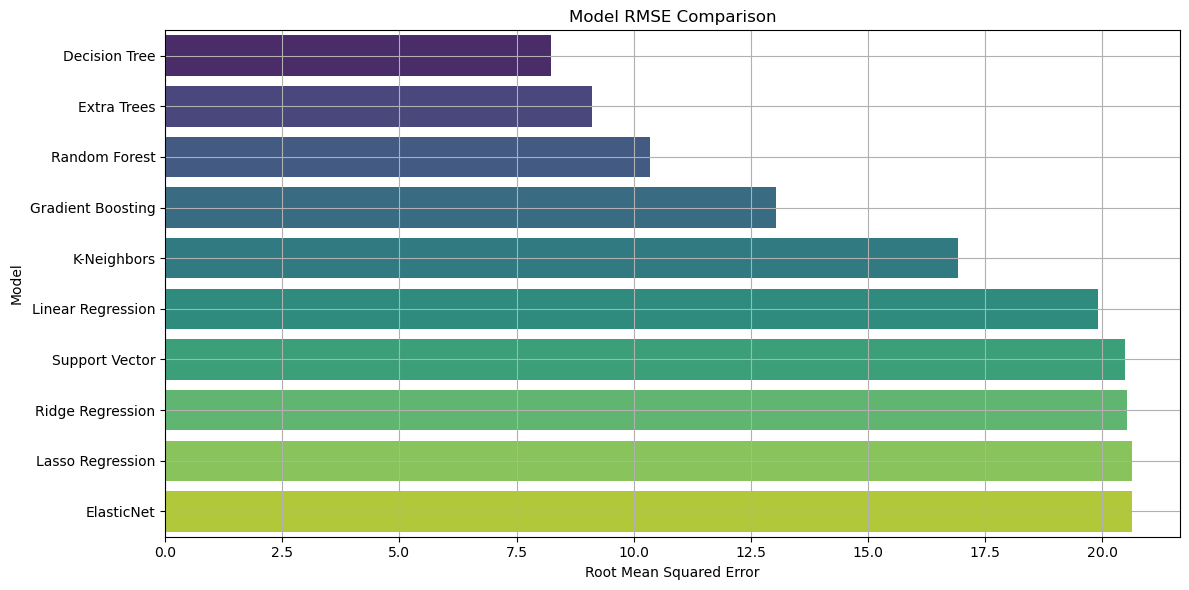

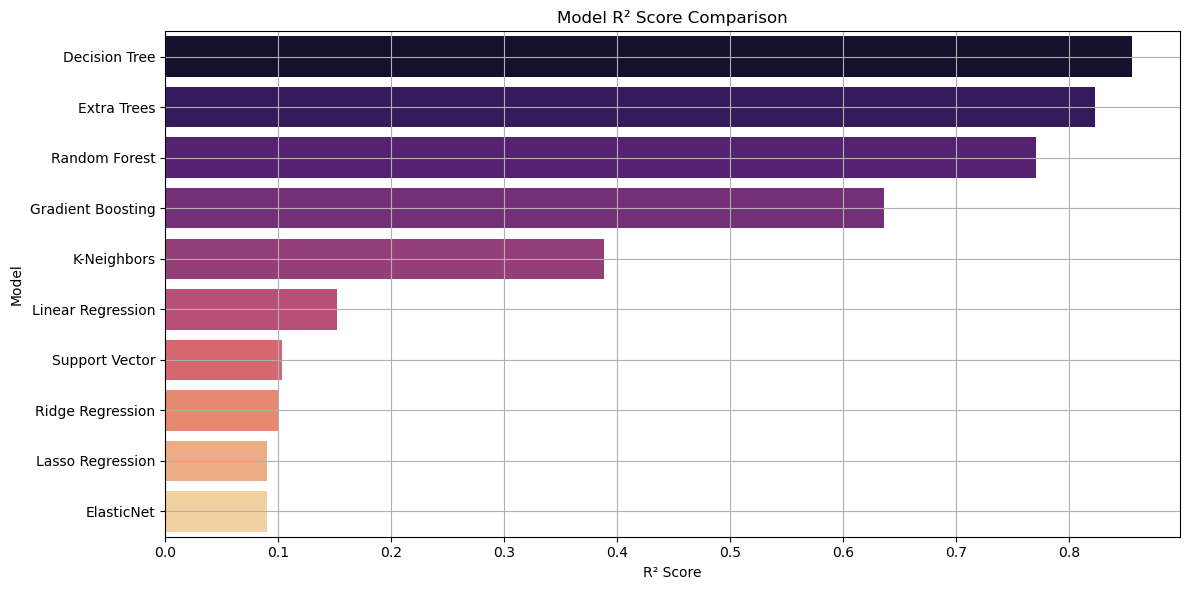

In [30]:
# Cell 6: Display results in a table and bar plots
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2']).sort_values(by='RMSE')

plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Model RMSE Comparison')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('Model')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='R2', y='Model', data=results_df.sort_values(by='R2', ascending=False), palette='magma')
plt.title('Model R² Score Comparison')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.grid(True)
plt.tight_layout()
plt.show()


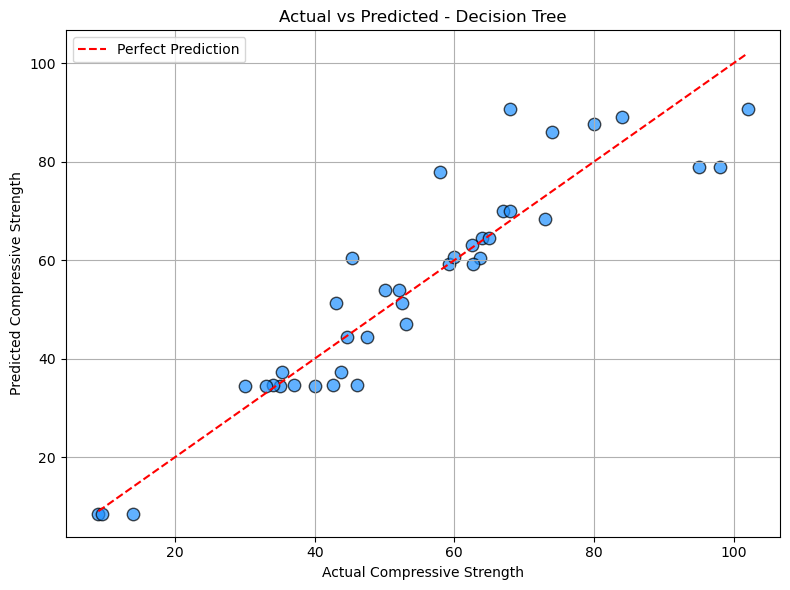

In [31]:
# Cell 7: Display best model predictions
best_model_name = sorted(best_models.items(), key=lambda x: x[1]['rmse'])[0][0]
best_model = best_models[best_model_name]['model']

# Predict on test set
y_pred = best_model.predict(X_test)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='dodgerblue', edgecolor='black', s=80, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.title(f'Actual vs Predicted - {best_model_name}')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Cell 8: Display all models summary

for name, result in best_models.items():
    print(f"Model: {name}")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  Best Params: {result['params']}")
    print("-" * 50)

Model: Linear Regression
  R² Score: 0.1523
  RMSE: 19.9094
  Best Params: {}
--------------------------------------------------
Model: Ridge Regression
  R² Score: 0.0997
  RMSE: 20.5175
  Best Params: {'regressor__alpha': 100.0}
--------------------------------------------------
Model: Lasso Regression
  R² Score: 0.0904
  RMSE: 20.6238
  Best Params: {'regressor__alpha': 1.0}
--------------------------------------------------
Model: ElasticNet
  R² Score: 0.0903
  RMSE: 20.6243
  Best Params: {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.1}
--------------------------------------------------
Model: Random Forest
  R² Score: 0.7709
  RMSE: 10.3506
  Best Params: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}
--------------------------------------------------
Model: Gradient Boosting
  R² Score: 0.6363
  RMSE: 13.0408
  Best Params: {'regressor__learning_rate': 0.2, 'regressor__n_estimators': 50}
--------------------------------------------------
Model: Extra Trees
 

In [33]:
# Cell 9: Display best model summary
print(f"The best model based on RMSE is: {best_model_name}")
print(f"Model R² Score: {best_models[best_model_name]['r2']:.4f}")
print(f"Model RSME Score: {best_models[best_model_name]['rmse']:.4f}")

The best model based on RMSE is: Decision Tree
Model R² Score: 0.8553
Model RSME Score: 8.2255


## want to make the saved model "aware" of its required input features so that when it's reloaded later, it can validate inputs and throw an error or warning if inputs are wrong or incomplete.

In [34]:
# Cell 10: Create Safe Regressor Class, this class ensures that the input features match the expected features of the model.

class SafeRegressor:
    def __init__(self, model, expected_features):
        self.model = model
        self.expected_features = expected_features

    def predict(self, X):
        # Check input type
        if isinstance(X, pd.DataFrame):
            # Check for missing or extra columns
            missing = [feat for feat in self.expected_features if feat not in X.columns]
            extra = [feat for feat in X.columns if feat not in self.expected_features]

            if missing:
                raise ValueError(f"Missing required feature(s): {missing}")
            if extra:
                raise ValueError(f"Unexpected extra feature(s): {extra}")

            # Reorder columns to match training order
            X = X[self.expected_features]

        elif isinstance(X, np.ndarray):
            if X.shape[1] != len(self.expected_features):
                raise ValueError(f"Expected {len(self.expected_features)} features, but got {X.shape[1]}.")
        else:
            raise TypeError("Input must be a pandas DataFrame or NumPy array")

        return self.model.predict(X)

    def get_feature_names(self):
        return self.expected_features


In [35]:
# Cell 11: Save the best model

expected_features = list(X_train.columns)

# CALLING SAFE REGRESSOR CLASS
safe_model = SafeRegressor(best_model, expected_features)

import joblib
joblib.dump(safe_model, 'best_model_regression_pipeline.pkl')

['best_model_regression_pipeline.pkl']

# To perform predictions using the saved model, refer to the separate notebook predict_regression_pipeline.ipynb
# This notebook is used only to train and save the model. 